In [1]:
import os
import numpy as np

import random
import nibabel as nib
from monai import transforms
import scipy.ndimage
from scipy.stats import norm
import matplotlib.pyplot as plt

# Seeds
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

In [2]:
folder = 'C:/'
imagesTr = folder + 'Task07_Pancreas/imagesTr/'
labelsTr = folder + 'Task07_Pancreas/labelsTr/'
def get_file_paths(data):
    file_paths = []
    for root, directories, files in os.walk(data):
        for filename in files:
            file_paths.append(os.path.join(root, filename))
    return file_paths
ct_paths = sorted(get_file_paths(imagesTr))
label_paths = sorted(get_file_paths(labelsTr))
print(f'ct_paths len: {len(ct_paths)}')
print(f'label_paths len: {len(label_paths)}')
# for file_path in  label_paths:
#     print(file_path)
for i in range(len(ct_paths)):
    if ct_paths[i][-20:-7] != label_paths[i][-20:-7]:
        print(f'Ass in {ct_paths[i][-20:-7]}')

In [ ]:
images_target_folder = folder + 'Augmentation/imagesTr/'
labels_target_folder = folder + 'Augmentation/labelsTr/'
print(f'Your output images folder: {images_target_folder}')
print(f'Your output labels folder: {labels_target_folder}')

In [5]:
# Augmentation data weighs a lot and takes a lot of time to generate, so it was decided to generate and save the data before training the neural network model where we use it
def augmentation(transform, ct_path, label_path):
    ct_name = ct_path[-19:-7] + postfix + ct_path[-7:]
    label_name = label_path[-19:-7] + postfix + label_path[-7:]
    original_ct_data = nib.load(ct_path)
    original_label_data = nib.load(label_path)
    original_ct_data_np = original_ct_data.get_fdata()
    original_label_data_np = original_label_data.get_fdata()
    ct_data = np.expand_dims(original_ct_data_np, axis=0)
    label_data = np.expand_dims(original_label_data_np, axis=0)
    data = {"ct": ct_data, "label": label_data}
    data = transform(data)
    ct_data = data["ct"]
    # if not isinstance(label_data, np.ndarray):
    label_data = data["label"]
    ct_data = np.squeeze(ct_data, axis=0)
    label_data = np.squeeze(label_data, axis=0)
    ct_data = np.round(ct_data, 0)
    ct_img = nib.Nifti1Image(ct_data, original_ct_data.affine)
    label_img = nib.Nifti1Image(label_data, original_label_data.affine)
    ct_save = images_target_folder+ct_name
    label_save = labels_target_folder+label_name
    nib.save(ct_img, ct_save)
    nib.save(label_img, label_save)
    # print(ct_save)
    # print(label_save)
    # rmse = np.sqrt(np.mean((original_ct_data_np - ct_data) ** 2))
    # print(f"Name: {ct_name}, RMSE: {rmse:.10f}")

In [35]:
# Here you can see and save the most loyal methods of CT data augmentation with a fixed range of changes
step = 0
for i in range(len(ct_paths)):
    F_tr = transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)]))
    R_tr = random.choice([
        transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
        transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
        transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
        transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
        transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
        transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
        transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=0, keep_size=True, mode=["bilinear", "nearest"])
        ])
    Z_tr = random.choice([
        transforms.RandZoomd(keys=['ct', 'label'], min_zoom=1.1, max_zoom=1.2, prob=1, mode=["area", "nearest-exact"]),
        transforms.RandZoomd(keys=['ct', 'label'], min_zoom=0.8, max_zoom=0.9, prob=1, mode=["area", "nearest-exact"])
        ])
    A_tr = transforms.RandAffined(keys=['ct', 'label'], mode=("bilinear", "nearest"), prob=1.0, shear_range=random.choice([(-0.5, -0.2), (0.2, 0.5)]))
    RF_tr = transforms.Compose([
        random.choice([
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=0, keep_size=True, mode=["bilinear", "nearest"])
            ]),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)]))
        ])
    ZF_tr = transforms.Compose([
        random.choice([
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=1.1, max_zoom=1.2, prob=1, mode=["area", "nearest-exact"]),
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=0.8, max_zoom=0.9, prob=1, mode=["area", "nearest-exact"])
            ]),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)]))
        ])
    AF_tr = transforms.Compose([
        transforms.RandAffined(keys=['ct', 'label'], mode=("bilinear", "nearest"), prob=1.0, shear_range=random.choice([(-0.5, -0.2), (0.2, 0.5)])),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)]))
        ])

    G_tr = transforms.RandGaussianSmoothd(keys=['ct'], prob=1, sigma_x = (0.8, 1.2), sigma_y = (0.8, 1.2), sigma_z = (0.8, 1.2))
    FG_tr = transforms.Compose([
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandGaussianSmoothd(keys=['ct'], prob=1, sigma_x = (0.8, 1.2), sigma_y = (0.8, 1.2), sigma_z = (0.8, 1.2))
        ])
    RG_tr = transforms.Compose([
        random.choice([
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=0, keep_size=True, mode=["bilinear", "nearest"])
            ]),
        transforms.RandGaussianSmoothd(keys=['ct'], prob=1, sigma_x = (0.8, 1.2), sigma_y = (0.8, 1.2), sigma_z = (0.8, 1.2))
        ])
    ZG_tr = transforms.Compose([
        random.choice([
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=1.1, max_zoom=1.2, prob=1, mode=["area", "nearest-exact"]),
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=0.8, max_zoom=0.9, prob=1, mode=["area", "nearest-exact"])
            ]),
        transforms.RandGaussianSmoothd(keys=['ct'], prob=1, sigma_x = (0.8, 1.2), sigma_y = (0.8, 1.2), sigma_z = (0.8, 1.2)),
        ])
    AG_tr = transforms.Compose([
        transforms.RandAffined(keys=['ct', 'label'], mode=("bilinear", "nearest"), prob=1.0, shear_range=random.choice([(-0.5, -0.2), (0.2, 0.5)])),
        transforms.RandGaussianSmoothd(keys=['ct'], prob=1, sigma_x = (0.8, 1.2), sigma_y = (0.8, 1.2), sigma_z = (0.8, 1.2))
        ])
    RFG_tr = transforms.Compose([
        random.choice([
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=0, keep_size=True, mode=["bilinear", "nearest"])
            ]),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandGaussianSmoothd(keys=['ct'], prob=1, sigma_x = (0.8, 1.2), sigma_y = (0.8, 1.2), sigma_z = (0.8, 1.2))
        ])
    ZFG_tr = transforms.Compose([
        random.choice([
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=1.1, max_zoom=1.2, prob=1, mode=["area", "nearest-exact"]),
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=0.8, max_zoom=0.9, prob=1, mode=["area", "nearest-exact"])
            ]),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandGaussianSmoothd(keys=['ct'], prob=1, sigma_x = (0.8, 1.2), sigma_y = (0.8, 1.2), sigma_z = (0.8, 1.2))
        ])
    AFG_tr = transforms.Compose([
        transforms.RandAffined(keys=['ct', 'label'], mode=("bilinear", "nearest"), prob=1.0, shear_range=random.choice([(-0.5, -0.2), (0.2, 0.5)])),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandGaussianSmoothd(keys=['ct'], prob=1, sigma_x = (0.8, 1.2), sigma_y = (0.8, 1.2), sigma_z = (0.8, 1.2))
        ])

    B_tr = transforms.RandBiasFieldd(keys=['ct'],prob=1, coeff_range=(0.05, 0.15))
    FB_tr = transforms.Compose([
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandBiasFieldd(keys=['ct'],prob=1, coeff_range=(0.05, 0.15))
        ])
    RB_tr = transforms.Compose([
        random.choice([
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=0, keep_size=True, mode=["bilinear", "nearest"])
            ]),
        transforms.RandBiasFieldd(keys=['ct'],prob=1, coeff_range=(0.05, 0.15))
        ])
    ZB_tr = transforms.Compose([
        random.choice([
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=1.1, max_zoom=1.2, prob=1, mode=["area", "nearest-exact"]),
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=0.8, max_zoom=0.9, prob=1, mode=["area", "nearest-exact"])
            ]),
        transforms.RandBiasFieldd(keys=['ct'],prob=1, coeff_range=(0.05, 0.15))
        ])
    AB_tr = transforms.Compose([
        transforms.RandAffined(keys=['ct', 'label'], mode=("bilinear", "nearest"), prob=1.0, shear_range=random.choice([(-0.5, -0.2), (0.2, 0.5)])),
        transforms.RandBiasFieldd(keys=['ct'],prob=1, coeff_range=(0.05, 0.15))
        ])
    RFB_tr = transforms.Compose([
        random.choice([
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=0, keep_size=True, mode=["bilinear", "nearest"])
            ]),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandBiasFieldd(keys=['ct'],prob=1, coeff_range=(0.05, 0.15))
        ])
    ZFB_tr = transforms.Compose([
        random.choice([
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=1.1, max_zoom=1.2, prob=1, mode=["area", "nearest-exact"]),
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=0.8, max_zoom=0.9, prob=1, mode=["area", "nearest-exact"])
            ]),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandBiasFieldd(keys=['ct'],prob=1, coeff_range=(0.05, 0.15))
        ])
    AFB_tr = transforms.Compose([
        transforms.RandAffined(keys=['ct', 'label'], mode=("bilinear", "nearest"), prob=1.0, shear_range=random.choice([(-0.5, -0.2), (0.2, 0.5)])),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandBiasFieldd(keys=['ct'],prob=1, coeff_range=(0.05, 0.15))
        ])

    C_tr = transforms.RandAdjustContrastd(keys=['ct'], prob=1, gamma=random.choice([(0.5, 0.9), (1.1, 1.5)]))
    FC_tr = transforms.Compose([
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandAdjustContrastd(keys=['ct'], prob=1, gamma=random.choice([(0.5, 0.9), (1.1, 1.5)]))
        ])
    RC_tr = transforms.Compose([
        random.choice([
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=0, keep_size=True, mode=["bilinear", "nearest"])
            ]),
        transforms.RandAdjustContrastd(keys=['ct'], prob=1, gamma=random.choice([(0.5, 0.9), (1.1, 1.5)]))
        ])
    ZC_tr = transforms.Compose([
        random.choice([
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=1.1, max_zoom=1.2, prob=1, mode=["area", "nearest-exact"]),
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=0.8, max_zoom=0.9, prob=1, mode=["area", "nearest-exact"])
            ]),
        transforms.RandAdjustContrastd(keys=['ct'], prob=1, gamma=random.choice([(0.5, 0.9), (1.1, 1.5)]))
        ])
    AC_tr = transforms.Compose([
        transforms.RandAffined(keys=['ct', 'label'], mode=("bilinear", "nearest"), prob=1.0, shear_range=random.choice([(-0.5, -0.2), (0.2, 0.5)])),
        transforms.RandAdjustContrastd(keys=['ct'], prob=1, gamma=random.choice([(0.5, 0.9), (1.1, 1.5)]))
        ])
    RFC_tr = transforms.Compose([
        random.choice([
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=0, range_z=random.choice([(-0.15, -0.1), (0.1, 0.15)]), keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=0, range_y=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_z=0, keep_size=True, mode=["bilinear", "nearest"]),
            transforms.RandRotated(keys=['ct', 'label'], prob=1, range_x=random.choice([(-0.15, -0.1), (0.1, 0.15)]), range_y=0, range_z=0, keep_size=True, mode=["bilinear", "nearest"])
            ]),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandAdjustContrastd(keys=['ct'], prob=1, gamma=random.choice([(0.5, 0.9), (1.1, 1.5)]))
        ])
    ZFC_tr = transforms.Compose([
        random.choice([
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=1.1, max_zoom=1.2, prob=1, mode=["area", "nearest-exact"]),
            transforms.RandZoomd(keys=['ct', 'label'], min_zoom=0.8, max_zoom=0.9, prob=1, mode=["area", "nearest-exact"])
            ]),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandAdjustContrastd(keys=['ct'], prob=1, gamma=random.choice([(0.5, 0.9), (1.1, 1.5)]))
        ])
    AFC_tr = transforms.Compose([
        transforms.RandAffined(keys=['ct', 'label'], mode=("bilinear", "nearest"), prob=1.0, shear_range=random.choice([(-0.5, -0.2), (0.2, 0.5)])),
        transforms.RandFlipd(keys=['ct', 'label'], prob=1, spatial_axis = random.choice([0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)])),
        transforms.RandAdjustContrastd(keys=['ct'], prob=1, gamma=random.choice([(0.5, 0.9), (1.1, 1.5)]))
        ])
    
    step += 1
    ct_path = ct_paths[i]
    label_path = label_paths[i]
    postfix = '_F'
    augmentation(F_tr, ct_path, label_path)
    postfix = '_R'
    augmentation(R_tr, ct_path, label_path)
    postfix = '_Z'
    augmentation(Z_tr, ct_path, label_path)
    postfix = '_A'
    augmentation(A_tr, ct_path, label_path)
    postfix = '_RF'
    augmentation(RF_tr, ct_path, label_path)
    postfix = '_ZF'
    augmentation(ZF_tr, ct_path, label_path)
    postfix = '_AF'
    augmentation(AF_tr, ct_path, label_path)

    postfix = '_G'
    augmentation(G_tr, ct_path, label_path)
    postfix = '_FG'
    augmentation(FG_tr, ct_path, label_path)
    postfix = '_RG'
    augmentation(RG_tr, ct_path, label_path)
    postfix = '_ZG'
    augmentation(ZG_tr, ct_path, label_path)
    postfix = '_AG'
    augmentation(AG_tr, ct_path, label_path)
    postfix = '_RFG'
    augmentation(RFG_tr, ct_path, label_path)
    postfix = '_ZFG'
    augmentation(ZFG_tr, ct_path, label_path)
    postfix = '_AFG'
    augmentation(AFG_tr, ct_path, label_path)
    
    postfix = '_B'
    augmentation(B_tr, ct_path, label_path)
    postfix = '_FB'
    augmentation(FB_tr, ct_path, label_path)
    postfix = '_RB'
    augmentation(RB_tr, ct_path, label_path)
    postfix = '_ZB'
    augmentation(ZB_tr, ct_path, label_path)
    postfix = '_AB'
    augmentation(AB_tr, ct_path, label_path)
    postfix = '_RFB'
    augmentation(RFB_tr, ct_path, label_path)
    postfix = '_ZFB'
    augmentation(ZFB_tr, ct_path, label_path)
    postfix = '_AFB'
    augmentation(AFB_tr, ct_path, label_path)

    postfix = '_C'
    augmentation(C_tr, ct_path, label_path)
    postfix = '_FC'
    augmentation(FC_tr, ct_path, label_path)
    postfix = '_RC'
    augmentation(RC_tr, ct_path, label_path)
    postfix = '_ZC'
    augmentation(ZC_tr, ct_path, label_path)
    postfix = '_AC'
    augmentation(AC_tr, ct_path, label_path)
    postfix = '_RFC'
    augmentation(RFC_tr, ct_path, label_path)
    postfix = '_ZFC'
    augmentation(ZFC_tr, ct_path, label_path)
    postfix = '_AFC'
    augmentation(AFC_tr, ct_path, label_path)
    
    print(f'Step: {step}')

Step: 1


In [7]:
# Define lists of file names for statistics
pre = 'C:/Task07_Pancreas/Augmentation/imagesTr'
file_names =  [i[-20:-7] for i in ct_paths]
O = ct_paths
R = [pre + i + '_R.nii.gz' for i in file_names]
Z = [pre + i + '_Z.nii.gz' for i in file_names]
A = [pre + i + '_A.nii.gz' for i in file_names]
FO = [pre + i + '_F.nii.gz' for i in file_names]
FR = [pre + i + '_RF.nii.gz' for i in file_names]
FZ = [pre + i + '_ZF.nii.gz' for i in file_names]
FA = [pre + i + '_AF.nii.gz' for i in file_names]
OB = [pre + i + '_B.nii.gz' for i in file_names]
OC = [pre + i + '_C.nii.gz' for i in file_names]
OG = [pre + i + '_G.nii.gz' for i in file_names]
RB = [pre + i + '_RB.nii.gz' for i in file_names]
RC = [pre + i + '_RC.nii.gz' for i in file_names]
RG = [pre + i + '_RG.nii.gz' for i in file_names]
ZB = [pre + i + '_ZB.nii.gz' for i in file_names]
ZC = [pre + i + '_ZC.nii.gz' for i in file_names]
ZG = [pre + i + '_ZG.nii.gz' for i in file_names]
AB = [pre + i + '_AB.nii.gz' for i in file_names]
AC = [pre + i + '_AC.nii.gz' for i in file_names]
AG = [pre + i + '_AG.nii.gz' for i in file_names]
FOB = [pre + i + '_FB.nii.gz' for i in file_names]
FOC = [pre + i + '_FC.nii.gz' for i in file_names]
FOG = [pre + i + '_FG.nii.gz' for i in file_names]
FRB = [pre + i + '_RFB.nii.gz' for i in file_names]
FRC = [pre + i + '_RFC.nii.gz' for i in file_names]
FRG = [pre + i + '_RFG.nii.gz' for i in file_names]
FZB = [pre + i + '_ZFB.nii.gz' for i in file_names]
FZC = [pre + i + '_ZFC.nii.gz' for i in file_names]
FZG = [pre + i + '_ZFG.nii.gz' for i in file_names]
FAB = [pre + i + '_AFB.nii.gz' for i in file_names]
FAC = [pre + i + '_AFC.nii.gz' for i in file_names]
FAG = [pre + i + '_AFG.nii.gz' for i in file_names]

In [35]:
def stat(ct_path):
    ct_image = nib.load(ct_path).get_fdata()
    # ct_image = scipy.ndimage.zoom(ct_image, (1, 1, 1), order=1)
    # min_value = np.min(ct_image)
    # max_value = np.max(ct_image)
    # ct_image = (ct_image - min_value) / (max_value - min_value)
    return (ct_image)

In [36]:
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data)
    z_score = norm.ppf((1 + confidence) / 2)
    margin_of_error = z_score * (std_dev / np.sqrt(n))
    return mean, margin_of_error

In [37]:
# Statistics
rmseR = []
rmseZ = []
rmseA = []
rmseFO = []
rmseFR = []
rmseFZ = []
rmseFA = []
rmseOB = []
rmseOC = []
rmseOG = []
rmseRB = []
rmseRC = []
rmseRG = []
rmseZB = []
rmseZC = []
rmseZG = []
rmseAB = []
rmseAC = []
rmseAG = []
rmseFOB = []
rmseFOC = []
rmseFOG = []
rmseFRB = []
rmseFRC = []
rmseFRG = []
rmseFZB = []
rmseFZC = []
rmseFZG = []
rmseFAB = []
rmseFAC = []
rmseFAG = []

procR = []
procZ = []
procA = []
procFO = []
procFR = []
procFZ = []
procFA = []
procOB = []
procOC = []
procOG = []
procRB = []
procRC = []
procRG = []
procZB = []
procZC = []
procZG = []
procAB = []
procAC = []
procAG = []
procFOB = []
procFOC = []
procFOG = []
procFRB = []
procFRC = []
procFRG = []
procFZB = []
procFZC = []
procFZG = []
procFAB = []
procFAC = []
procFAG = []
for n in range (len(O)):
    On = stat(O[n])
    dif = np.max(On)-np.min(On)
    Rn = np.sqrt(np.mean((On - stat(R[n])) ** 2))
    Zn = np.sqrt(np.mean((On - stat(Z[n])) ** 2))
    An = np.sqrt(np.mean((On - stat(A[n])) ** 2))
    FOn = np.sqrt(np.mean((On - stat(FO[n])) ** 2))
    FRn = np.sqrt(np.mean((On - stat(FR[n])) ** 2))
    FZn = np.sqrt(np.mean((On - stat(FZ[n])) ** 2))
    FAn = np.sqrt(np.mean((On - stat(FA[n])) ** 2))
    OBn = np.sqrt(np.mean((On - stat(OB[n])) ** 2))
    OCn = np.sqrt(np.mean((On - stat(OC[n])) ** 2))
    OGn = np.sqrt(np.mean((On - stat(OG[n])) ** 2))
    RBn = np.sqrt(np.mean((On - stat(RB[n])) ** 2))
    RCn = np.sqrt(np.mean((On - stat(RC[n])) ** 2))
    RGn = np.sqrt(np.mean((On - stat(RG[n])) ** 2))
    ZBn = np.sqrt(np.mean((On - stat(ZB[n])) ** 2))
    ZCn = np.sqrt(np.mean((On - stat(ZC[n])) ** 2))
    ZGn = np.sqrt(np.mean((On - stat(ZG[n])) ** 2))
    ABn = np.sqrt(np.mean((On - stat(AB[n])) ** 2))
    ACn = np.sqrt(np.mean((On - stat(AC[n])) ** 2))
    AGn = np.sqrt(np.mean((On - stat(AG[n])) ** 2))
    FOBn = np.sqrt(np.mean((On - stat(FOB[n])) ** 2))
    FOCn = np.sqrt(np.mean((On - stat(FOC[n])) ** 2))
    FOGn = np.sqrt(np.mean((On - stat(FOG[n])) ** 2))
    FRBn = np.sqrt(np.mean((On - stat(FRB[n])) ** 2))
    FRCn = np.sqrt(np.mean((On - stat(FRC[n])) ** 2))
    FRGn = np.sqrt(np.mean((On - stat(FRG[n])) ** 2))
    FZBn = np.sqrt(np.mean((On - stat(FZB[n])) ** 2))
    FZCn = np.sqrt(np.mean((On - stat(FZC[n])) ** 2))
    FZGn = np.sqrt(np.mean((On - stat(FZG[n])) ** 2))
    FABn = np.sqrt(np.mean((On - stat(FAB[n])) ** 2))
    FACn = np.sqrt(np.mean((On - stat(FAC[n])) ** 2))
    FAGn = np.sqrt(np.mean((On - stat(FAG[n])) ** 2))

    proc = Rn/dif
    procR.append(proc)
    rmseR.append(Rn)

    proc = Zn/dif
    procZ.append(proc)
    rmseZ.append(Zn)

    proc = An/dif
    procA.append(proc)
    rmseA.append(An)

    proc = FOn/dif
    procFO.append(proc)
    rmseFO.append(FOn)

    proc = FRn/dif
    procFR.append(proc)
    rmseFR.append(FRn)

    proc = FZn/dif
    procFZ.append(proc)
    rmseFZ.append(FZn)

    proc = FAn/dif
    procFA.append(proc)
    rmseFA.append(FAn)

    proc = OBn/dif
    procOB.append(proc)
    rmseOB.append(OBn)

    proc = OCn/dif
    procOC.append(proc)
    rmseOC.append(OCn)

    proc = OGn/dif
    procOG.append(proc)
    rmseOG.append(OGn)

    proc = RBn/dif
    procRB.append(proc)
    rmseRB.append(RBn)

    proc = RCn/dif
    procRC.append(proc)
    rmseRC.append(RCn)

    proc = RGn/dif
    procRG.append(proc)
    rmseRG.append(RGn)

    proc = ZBn/dif
    procZB.append(proc)
    rmseZB.append(ZBn)

    proc = ZCn/dif
    procZC.append(proc)
    rmseZC.append(ZCn)

    proc = ZGn/dif
    procZG.append(proc)
    rmseZG.append(ZGn)

    proc = ABn/dif
    procAB.append(proc)
    rmseAB.append(ABn)

    proc = ACn/dif
    procAC.append(proc)
    rmseAC.append(ACn)

    proc = AGn/dif
    procAG.append(proc)
    rmseAG.append(AGn)

    proc = FOBn/dif
    procFOB.append(proc)
    rmseFOB.append(FOBn)

    proc = FOCn/dif
    procFOC.append(proc)
    rmseFOC.append(FOCn)

    proc = FOGn/dif
    procFOG.append(proc)
    rmseFOG.append(FOGn)

    proc = FRBn/dif
    procFRB.append(proc)
    rmseFRB.append(FRBn)

    proc = FRCn/dif
    procFRC.append(proc)
    rmseFRC.append(FRCn)

    proc = FRGn/dif
    procFRG.append(proc)
    rmseFRG.append(FRGn)

    proc = FZBn/dif
    procFZB.append(proc)
    rmseFZB.append(FZBn)

    proc = FZCn/dif
    procFZC.append(proc)
    rmseFZC.append(FZCn)

    proc = FZGn/dif
    procFZG.append(proc)
    rmseFZG.append(FZGn)

    proc = FABn/dif
    procFAB.append(proc)
    rmseFAB.append(FABn)

    proc = FACn/dif
    procFAC.append(proc)
    rmseFAC.append(FACn)

    proc = FAGn/dif
    procFAG.append(proc)
    rmseFAG.append(FAGn)

In [ ]:
print(np.round(sum(rmseR) / len(rmseR), 4))
print(np.round(sum(procR) / len(procR)*100, 2))
data = rmseR
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Rotate')
print()
print(np.round(sum(rmseZ) / len(rmseZ), 4))
print(np.round(sum(procZ) / len(procZ)*100, 2))
data = rmseZ
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Zoom')
print()
print(np.round(sum(rmseA) / len(rmseA), 4))
print(np.round(sum(procA) / len(procA)*100, 2))
data = rmseA
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Affine')
print()
print(np.round(sum(rmseFO) / len(rmseFO), 4))
print(np.round(sum(procFO) / len(procFO)*100, 2))
data = rmseFO
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip')
print()
print(np.round(sum(rmseFR) / len(rmseFR), 4))
print(np.round(sum(procFR) / len(procFR)*100, 2))
data = rmseFR
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Rotate')
print()
print(np.round(sum(rmseFZ) / len(rmseFZ), 4))
print(np.round(sum(procFZ) / len(procFZ)*100, 2))
data = rmseFZ
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Zoom')
print()
print(np.round(sum(rmseFA) / len(rmseFA), 4))
print(np.round(sum(procFA) / len(procFA)*100, 2))
data = rmseFA
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Affine')
print()
print(np.round(sum(rmseOB) / len(rmseOB), 4))
print(np.round(sum(procOB) / len(procOB)*100, 2))
data = rmseOB
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Bias')
print()
print(np.round(sum(rmseOC) / len(rmseOC), 4))
print(np.round(sum(procOC) / len(procOC)*100, 2))
data = rmseOC
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Contrast')
print()
print(np.round(sum(rmseOG) / len(rmseOG), 4))
print(np.round(sum(procOG) / len(procOG)*100, 2))
data = rmseOG
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Gauss')
print()
print(np.round(sum(rmseRB) / len(rmseRB), 4))
print(np.round(sum(procRB) / len(procRB)*100, 2))
data = rmseRB
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Rotate + Bias')
print()
print(np.round(sum(rmseRC) / len(rmseRC), 4))
print(np.round(sum(procRC) / len(procRC)*100, 2))
data = rmseRC
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Rotate + Contrast')
print()
print(np.round(sum(rmseRG) / len(rmseRG), 4))
print(np.round(sum(procRG) / len(procRG)*100, 2))
data = rmseRG
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Rotate + Gauss')
print()
print(np.round(sum(rmseZB) / len(rmseZB), 4))
print(np.round(sum(procZB) / len(procZB)*100, 2))
data = rmseZB
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Zoom + Bias')
print()
print(np.round(sum(rmseZC) / len(rmseZC), 4))
print(np.round(sum(procZC) / len(procZC)*100, 2))
data = rmseZC
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Zoom + Contrast')
print()
print(np.round(sum(rmseZG) / len(rmseZG), 4))
print(np.round(sum(procZG) / len(procZG)*100, 2))
data = rmseZG
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Zoom + Gauss')
print()
print(np.round(sum(rmseAB) / len(rmseAB), 4))
print(np.round(sum(procAB) / len(procAB)*100, 2))
data = rmseAB
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Affine + Bias')
print()
print(np.round(sum(rmseAC) / len(rmseAC), 4))
print(np.round(sum(procAC) / len(procAC)*100, 2))
data = rmseAC
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Affine + Contrast')
print()
print(np.round(sum(rmseAG) / len(rmseAG), 4))
print(np.round(sum(procAG) / len(procAG)*100, 2))
data = rmseAG
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Affine + Gauss')
print()
print(np.round(sum(rmseFOB) / len(rmseFOB), 4))
print(np.round(sum(procFOB) / len(procFOB)*100, 2))
data = rmseFOB
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Bias')
print()
print(np.round(sum(rmseFOC) / len(rmseFOC), 4))
print(np.round(sum(procFOC) / len(procFOC)*100, 2))
data = rmseFOC
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Contrast')
print()
print(np.round(sum(rmseFOG) / len(rmseFOG), 4))
print(np.round(sum(procFOG) / len(procFOG)*100, 2))
data = rmseFOG
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Gauss')
print()
print(np.round(sum(rmseFRB) / len(rmseFRB), 4))
print(np.round(sum(procFRB) / len(procFRB)*100, 2))
data = rmseFRB
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Rotate + Bias')
print()
print(np.round(sum(rmseFRC) / len(rmseFRC), 4))
print(np.round(sum(procFRC) / len(procFRC)*100, 2))
data = rmseFRC
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Rotate + Contrast')
print()
print(np.round(sum(rmseFRG) / len(rmseFRG), 4))
print(np.round(sum(procFRG) / len(procFRG)*100, 2))
data = rmseFRG
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Rotate + Gauss')
print()
print(np.round(sum(rmseFZB) / len(rmseFZB), 4))
print(np.round(sum(procFZB) / len(procFZB)*100, 2))
data = rmseFZB
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Zoom + Bias')
print()
print(np.round(sum(rmseFZC) / len(rmseFZC), 4))
print(np.round(sum(procFZC) / len(procFZC)*100, 2))
data = rmseFZC
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Zoom + Contrast')
print()
print(np.round(sum(rmseFZG) / len(rmseFZG), 4))
print(np.round(sum(procFZG) / len(procFZG)*100, 2))
data = rmseFZG
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Zoom + Gauss')
print()
print(np.round(sum(rmseFAB) / len(rmseFAB), 4))
print(np.round(sum(procFAB) / len(procFAB)*100, 2))
data = rmseFAB
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Affine + Bias')
print()
print(np.round(sum(rmseFAC) / len(rmseFAC), 4))
print(np.round(sum(procFAC) / len(procFAC)*100, 2))
data = rmseFAC
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Affine + Contrast')
print()
print(np.round(sum(rmseFAG) / len(rmseFAG), 4))
print(np.round(sum(procFAG) / len(procFAG)*100, 2))
data = rmseFAG
mean, margin = confidence_interval(data)
print("{:.3f}±{:.3f}".format(mean, margin))
print('Flip + Affine + Gauss')

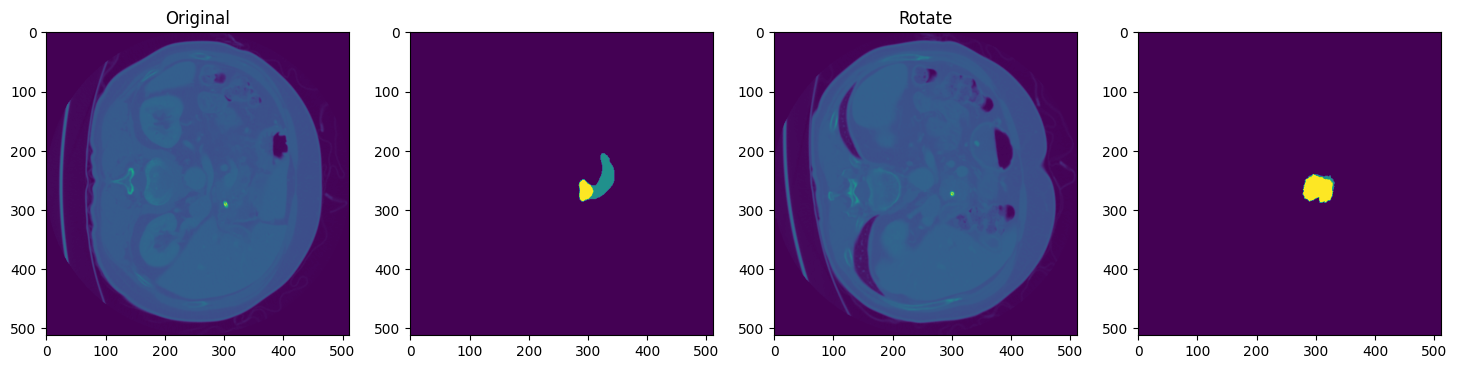

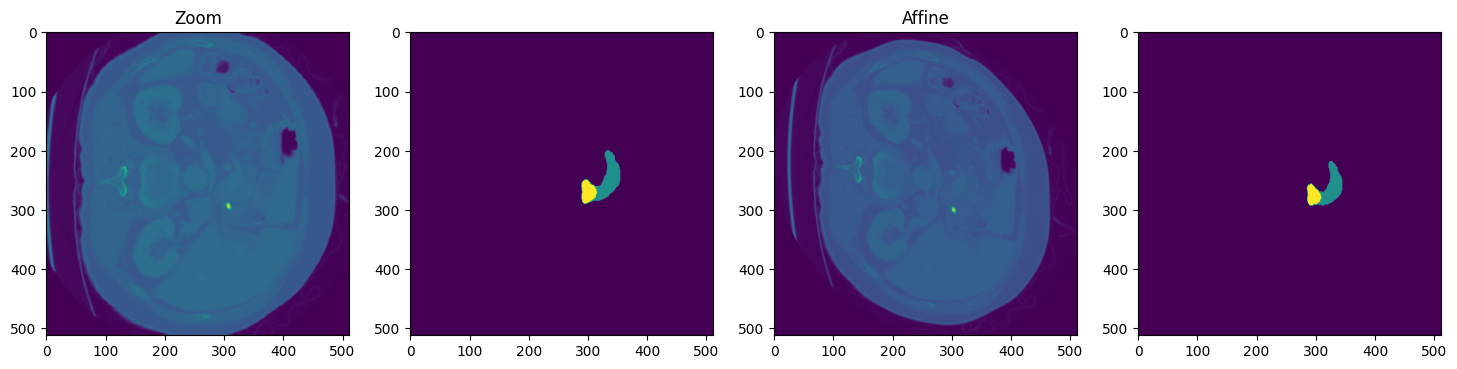

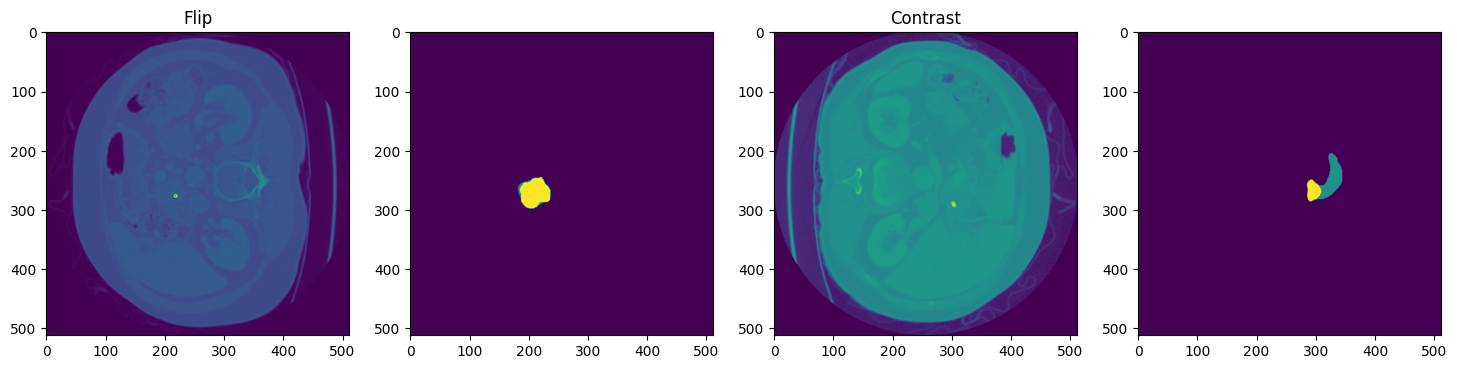

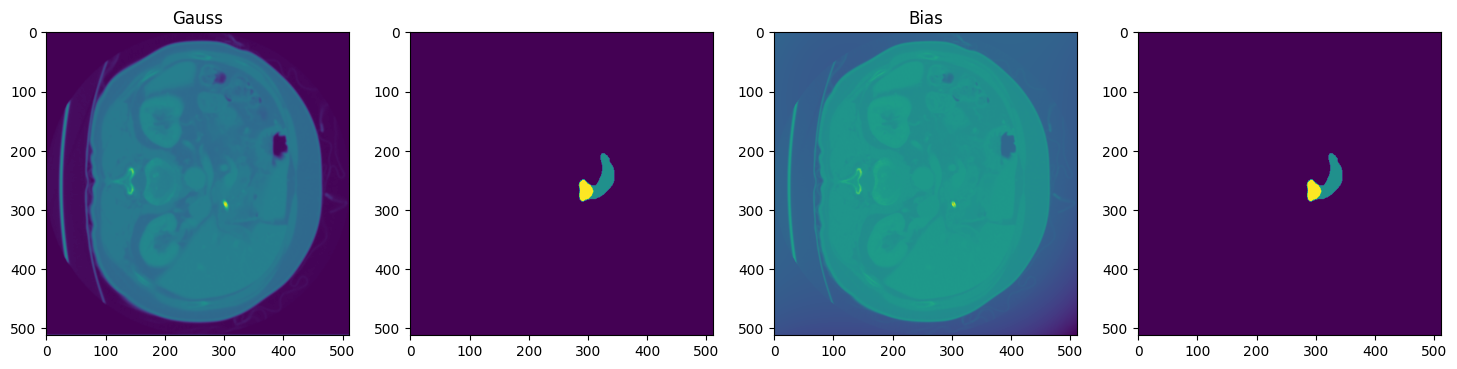

In [6]:
# Visualization of augmentation results
original_ct_data = nib.load('C:/Task07_Pancreas/imagesTr/pancreas_001.nii.gz')
original_label_data = nib.load('C:/Task07_Pancreas/labelsTr/pancreas_001.nii.gz')
ct_dataR = nib.load('C:/Task07_Pancreas/Augmentation/imagesTr/pancreas_001_R.nii.gz')
label_dataR = nib.load('C:/Task07_Pancreas/Augmentation/labelsTr/pancreas_001_R.nii.gz')
ct_dataZ = nib.load('C:/Task07_Pancreas/Augmentation/imagesTr/pancreas_001_Z.nii.gz')
label_dataZ = nib.load('C:/Task07_Pancreas/Augmentation/labelsTr/pancreas_001_Z.nii.gz')
ct_dataA = nib.load('C:/Task07_Pancreas/Augmentation/imagesTr/pancreas_001_A.nii.gz')
label_dataA = nib.load('C:/Task07_Pancreas/Augmentation/labelsTr/pancreas_001_A.nii.gz')
ct_dataF = nib.load('C:/Task07_Pancreas/Augmentation/imagesTr/pancreas_001_F.nii.gz')
label_dataF = nib.load('C:/Task07_Pancreas/Augmentation/labelsTr/pancreas_001_F.nii.gz')
ct_dataC = nib.load('C:/Task07_Pancreas/Augmentation/imagesTr/pancreas_001_C.nii.gz')
label_dataC = nib.load('C:Task07_Pancreas/Augmentation/labelsTr/pancreas_001_C.nii.gz')
ct_dataG = nib.load('C:/Task07_Pancreas/Augmentation/imagesTr/pancreas_001_G.nii.gz')
label_dataG = nib.load('C:/Task07_Pancreas/Augmentation/labelsTr/pancreas_001_G.nii.gz')
ct_dataB = nib.load('C:/Task07_Pancreas/Augmentation/imagesTr/pancreas_001_B.nii.gz')
label_dataB = nib.load('C:/Task07_Pancreas/Augmentation/labelsTr/pancreas_001_B.nii.gz')


original_ct_data = original_ct_data.get_fdata()
original_label_data = original_label_data.get_fdata()
ct_dataR = ct_dataR.get_fdata()
label_dataR = label_dataR.get_fdata()
ct_dataZ = ct_dataZ.get_fdata()
label_dataZ = label_dataZ.get_fdata()
ct_dataA = ct_dataA.get_fdata()
label_dataA = label_dataA.get_fdata()
ct_dataF = ct_dataF.get_fdata()
label_dataF = label_dataF.get_fdata()
ct_dataC = ct_dataC.get_fdata()
label_dataC = label_dataC.get_fdata()
ct_dataG = ct_dataG.get_fdata()
label_dataG = label_dataG.get_fdata()
ct_dataB = ct_dataB.get_fdata()
label_dataB = label_dataB.get_fdata()

i = 36

original_ar = original_ct_data[:,:,i]
ar = original_label_data[:,:,i]
original_ar_lbl = ct_dataR[:,:,i] 
ar_lbl = label_dataR[:,:,i]

fig = plt.figure(figsize=(18,15))


plt.subplot(1,4,1)
plt.imshow(original_ar)
plt.title('Original')

plt.subplot(1,4,2)
plt.imshow(ar)

plt.subplot(1,4,3)
plt.imshow(original_ar_lbl)
plt.title('Rotate')

plt.subplot(1,4,4)
plt.imshow(ar_lbl)

plt.show()

original_ar = ct_dataZ[:,:,i]
ar = label_dataZ[:,:,i]
original_ar_lbl = ct_dataA[:,:,i]
ar_lbl = label_dataA[:,:,i]

fig = plt.figure(figsize=(18,15))


plt.subplot(1,4,1)
plt.imshow(original_ar)
plt.title('Zoom')

plt.subplot(1,4,2)
plt.imshow(ar)

plt.subplot(1,4,3)
plt.imshow(original_ar_lbl)
plt.title('Affine')

plt.subplot(1,4,4)
plt.imshow(ar_lbl)

plt.show()

original_ar = ct_dataF[:,:,i]
ar = label_dataF[:,:,i]
original_ar_lbl = ct_dataC[:,:,i]
ar_lbl = label_dataC[:,:,i]

fig = plt.figure(figsize=(18,15))


plt.subplot(1,4,1)
plt.imshow(original_ar)
plt.title('Flip')

plt.subplot(1,4,2)
plt.imshow(ar)

plt.subplot(1,4,3)
plt.imshow(original_ar_lbl)
plt.title('Contrast')

plt.subplot(1,4,4)
plt.imshow(ar_lbl)

plt.show()

original_ar = ct_dataG[:,:,i]
ar = label_dataG[:,:,i]
original_ar_lbl = ct_dataB[:,:,i]
ar_lbl = label_dataB[:,:,i]

fig = plt.figure(figsize=(18,15))


plt.subplot(1,4,1)
plt.imshow(original_ar)
plt.title('Gauss')

plt.subplot(1,4,2)
plt.imshow(ar)

plt.subplot(1,4,3)
plt.imshow(original_ar_lbl)
plt.title('Bias')

plt.subplot(1,4,4)
plt.imshow(ar_lbl)

plt.show()